In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import torch.nn.functional as F
#environment
import gym
import os
import time
#pytorch
import torch
from torch.autograd import Variable
import torch.nn as nn
from math import sqrt


logging_interval = 40
animate_interval = logging_interval * 5
logdir='./DDPG/'

In [2]:
VISUALIZE = False
SEED = 0
MAX_PATH_LENGTH = 500
NUM_EPISODES = 12000
GAMMA=0.99
BATCH_SIZE = 128

# Environments to be tested on
env_name = 'InvertedDoublePendulum-v1'
#env_name = 'Pendulum-v0'
#env_name = 'HalfCheetah-v1' 

# wrap gym to save videos
env = gym.make(env_name)
if VISUALIZE:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env = gym.wrappers.Monitor(env, logdir, force=True, video_callable=lambda episode_id: episode_id%logging_interval==0)
env._max_episodes_steps = MAX_PATH_LENGTH

# check observation and action space
discrete = isinstance(env.action_space, gym.spaces.Discrete)
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n if discrete else env.action_space.shape[0]

if discrete:
    print("This is a discrete action space, probably not the right algorithm to use")

# set random seeds
torch.manual_seed(SEED)
np.random.seed(SEED)

# make variable types for automatic setting to GPU or CPU, depending on GPU availability
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor
Tensor = FloatTensor

[2018-06-04 17:27:48,958] Making new env: InvertedDoublePendulum-v1


In [3]:
class NormalizeAction(gym.ActionWrapper):
    def action(self, action):
        action = (action + 1) / 2  
        action *= (self.action_space.high - self.action_space.low)
        action += self.action_space.low
        return action

    def reverse_action(self, action):
        action -= self.action_space.low
        action /= (self.action_space.high - self.action_space.low)
        a
        ction = action * 2 - 1
        return actions


In [4]:
def weightSync(target_model, source_model, tau = 0.001):
    for parameter_target, parameter_source in zip(target_model.parameters(), source_model.parameters()):
        parameter_target.data.copy_((1 - tau) * parameter_target.data + tau * parameter_source.data)

In [5]:
from collections import deque
import random

class Replay(object):
    def __init__(self, maxlen = 60000):
        self.maxlen = maxlen
        #self.data = deque(maxlen = self.maxlen)
        self.data=[]
        self.position=0

        self.initialize(init_length=1000, envir=env)
    def initialize(self,init_length=1000, envir=env):
        s = envir.reset()
        for i in range (init_length):
            #a = np.random.random(1)-np.random.random(1)
            a = env.action_space.sample()
            s1, r, done, _ = env.step(a)            
            self.add([np.reshape(s,(1,obs_dim)), np.reshape(a,(1,act_dim)), r, done, np.reshape(s1,(1,obs_dim))])
                        
            if done:
                s=envir.reset()
            else: 
                s = s1  
             
         
    def add(self, ep):
        self.data.append(ep)
        self.position = (self.position + 1) % self.maxlen       
        #self.data[self.position] = tuple(ep)
        
    def sample(self, nsamples):
        if nsamples > len(self.data):
            return random.sample(self.data, len(self.data))
        else:
            return random.sample(self.data, nsamples)

    def display(self):
        for x in self.data:
            print (x) 

In [6]:
class OrnsteinUhlenbeckProcess:
    def __init__(self, mu=np.zeros(act_dim), sigma=0.05, theta=.25, dimension=1e-2, x0=None,num_steps=12000):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dimension
        self.x0 = x0
        self.reset()

    def step(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
                self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)

In [7]:
# ----------------------------------------------------
# actor model, MLP
# ----------------------------------------------------
# 2 hidden layers, 400 units per layer, tanh output to bound outputs between -1 and 1

class critic(nn.Module):

    def __init__(self, state_size, action_size,output_size = 1):
        super(critic, self).__init__()

        self.state_dim = state_size
        self.action_dim = action_size
        h1_dim = 300
        h2_dim = 300

        self.fc1 = nn.Linear(self.state_dim,h1_dim)
        
        #self.bn1 = nn.BatchNorm1d(h1_dim)
        
        self.fc2 = nn.Linear(h1_dim + self.action_dim,h2_dim)
        
        self.fc3 = nn.Linear(h2_dim,output_size)


    def forward(self, sa):
        state, action =sa
        #s1 = F.relu(self.bn1(self.fc1(state)))
        s1 = F.relu(self.fc1(state))

        x = torch.cat((s1,action),dim=1)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class actor(nn.Module):

    def __init__(self, input_size, output_size):
        super(actor, self).__init__()

        self.state_dim = input_size
        self.action_dim = output_size
        h1_dim = 400
        h2_dim = 400

        self.fc1 = nn.Linear(self.state_dim,h1_dim)
        #self.bn1 = nn.BatchNorm1d(h1_dim)

        self.fc2 = nn.Linear(h1_dim,h2_dim)
        #self.bn2 = nn.BatchNorm1d(h2_dim)

        self.fc3 = nn.Linear(h2_dim,self.action_dim)

        
    def forward(self, state):
        #x = F.relu(self.bn1(self.fc1(state)))
        #x = F.relu(self.bn2(self.fc2(x)))
        
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        action = F.tanh(self.fc3(x))

        return action
    

In [8]:
class DDPG:
    def __init__(self, obs_dim, act_dim, critic_lr = 1e-3, actor_lr = 1e-4, gamma = GAMMA, batch_size = BATCH_SIZE):
        
        self.gamma = GAMMA
        self.batch_size = BATCH_SIZE
        
        # actor
        self.actor = actor(input_size = obs_dim, output_size = act_dim).type(FloatTensor)
        self.actor_perturbed = actor(input_size = obs_dim, output_size = act_dim).type(FloatTensor)
        self.actor_target = actor(input_size = obs_dim, output_size = act_dim).type(FloatTensor)
        self.actor_target.load_state_dict(self.actor.state_dict())

        # critic
        self.critic = critic(state_size = obs_dim, action_size = act_dim, output_size = 1).type(FloatTensor)
        self.critic_target = critic(state_size = obs_dim, action_size = act_dim, output_size = 1).type(FloatTensor)
        self.critic_target.load_state_dict(self.critic.state_dict())
        if use_cuda:
            self.actor.cuda()
            self.actor_target.cuda()
            self.critic.cuda()
            self.critic_target.cuda()
        # optimizers
        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr = actor_lr)
        self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr = critic_lr, weight_decay=1e-2)
        
        # critic loss
        self.critic_loss = nn.MSELoss()
        
        # noise
        self.noise = OrnsteinUhlenbeckProcess(dimension = act_dim, num_steps = NUM_EPISODES)

        # replay buffer 
        self.replayBuffer = Replay()

        
    def action(self, s, noise, para):
        obs = torch.from_numpy(s).unsqueeze(0)
        inp = Variable(obs,requires_grad=False).type(FloatTensor)

        self.actor.eval()
        self.actor_perturbed.eval()

        if para is not None:
            a = self.actor_perturbed(inp).data[0].cpu().numpy() 
        else:
            a = self.actor(inp).data[0].cpu().numpy() 
        self.actor.train()

        if noise is not None:
            a = a + noise
        return a
    

    def perturb_actor_parameters(self, param_noise):
        """Apply parameter noise to actor model, for exploration"""
        hard_update(self.actor_perturbed, self.actor)
        params = self.actor_perturbed.state_dict()
        for name in params:
            if 'ln' in name: 
                pass 
            param = params[name]
            random = torch.randn(param.shape)
            if use_cuda:
                random = random.cuda()
            param += random * param_noise.current_stddev
    
    
    def train(self,training_data):
        # sample from Replay
        batch_s = np.vstack(training_data[:,0])
        batch_a = np.vstack(training_data[:,1])
        batch_s1 = np.vstack(training_data[:,4])
        batch_r = np.array(training_data[:,2]).astype("float")
        batch_done = np.array(training_data[:,3]).astype("float")
        
        s1 = Variable(torch.from_numpy(batch_s)).type(FloatTensor)
        a1 = Variable(torch.from_numpy(batch_a)).type(FloatTensor)
        r1 = Variable(torch.from_numpy(batch_r[:,None]),volatile = True).type(FloatTensor)
        s2 = Variable(torch.from_numpy(batch_s1), volatile = True).type(FloatTensor)
        d  = Variable(torch.from_numpy(1.0*batch_done)[:,None]).type(FloatTensor)

       
        a2 = self.actor_target.forward(s2)
        # ---------------------- optimize critic ----------------------

        next_val = self.critic_target((s2, a2)).detach()
        
        q_expected = r1 + self.gamma*next_val*(1.0-d)
        
        # y_pred = Q( s1, a1)
        q_predicted = self.critic((s1, a1))

        
        #print (y_predicted.volatile)
        #print (y_expected.volatile)

        # compute critic loss, and update the critic
        loss_critic = self.critic_loss(q_predicted, q_expected)
        self.optimizer_critic.zero_grad()
        #print (loss_critic.volatile)
        loss_critic.backward()
        self.optimizer_critic.step()

        # ---------------------- optimize actor ----------------------
        pred_a1 = self.actor.forward(s1)
        loss_actor = -1*self.critic.forward((s1, pred_a1))
        loss_actor = loss_actor.mean()
        #input()
        self.optimizer_actor.zero_grad()
        loss_actor.backward()
        #print (loss_actor.volatile)
        self.optimizer_actor.step()
        
        # sychronize target network with fast moving one
        weightSync(self.critic_target, self.critic)
        weightSync(self.actor_target, self.actor)
        

In [9]:
ddpg = DDPG(obs_dim = obs_dim, act_dim = act_dim)
# print(ddpg.actor)
# print(ddpg.critic)

In [10]:
class AdaptiveParamNoiseSpec(object):
    def __init__(self, initial_stddev=0.1, desired_action_stddev=0.2, adaptation_coefficient=1.01):
        """
        Note that initial_stddev and current_stddev refer to std of parameter noise, 
        but desired_action_stddev refers to (as name notes) desired std in action space
        """
        self.initial_stddev = initial_stddev
        self.desired_action_stddev = desired_action_stddev
        self.adaptation_coefficient = adaptation_coefficient

        self.current_stddev = initial_stddev

    def adapt(self, distance):
        if distance > self.desired_action_stddev:
            # Decrease stddev.
            self.current_stddev /= self.adaptation_coefficient
        else:
            # Increase stddev.
            self.current_stddev *= self.adaptation_coefficient

    def get_stats(self):
        stats = {
            'param_noise_stddev': self.current_stddev,
        }
        return stats

    def __repr__(self):
        fmt = 'AdaptiveParamNoiseSpec(initial_stddev={}, desired_action_stddev={}, adaptation_coefficient={})'
        return fmt.format(self.initial_stddev, self.desired_action_stddev, self.adaptation_coefficient)

def ddpg_distance_metric(actions1, actions2):
    """
    Compute "distance" between actions taken by two policies at the same states
    Expects numpy arrays
    """
    diff = actions1-actions2
    mean_diff = np.mean(np.square(diff), axis=0)
    dist = sqrt(np.mean(mean_diff))
    return dist


def hard_update(target, source):
    for target_param, param in zip(target.parameters(), source.parameters()):
           target_param.data.copy_(param.data)


In [11]:
env = NormalizeAction(env) # remap action values for the environment
avg_val = 0

#for plotting
running_rewards_ddpg = []
step_list_ddpg = []
step_counter = 0

# set term_condition for early stopping according to environment being used
#term_condition = -150 # Pendulum
term_condition = 50000 # inverted Pendulum
#term_condition = 1500 # half cheetah

param_noise = AdaptiveParamNoiseSpec(initial_stddev=0.05,desired_action_stddev=0.3, adaptation_coefficient=1.05)

for itr in range(NUM_EPISODES):
    s=env.reset() # get initial state
    animate_this_episode = (itr % animate_interval == 0) and VISUALIZE
    total_reward=0
    ddpg.perturb_actor_parameters(param_noise)
    #actor_noise = OrnsteinUhlenbeckProcess(mu=np.zeros(act_dim))
    noise_counter=0
    while True:
        ddpg.noise.reset()
        if animate_this_episode:
                env.render('rgb_array')
                time.sleep(0.05)
        a = ddpg.action(s, ddpg.noise.step(),param_noise)
        #a = ddpg.action(s, None, param_noise)
        s1, r, done, _ = env.step(a)
        total_reward += r

        ddpg.replayBuffer.add([np.reshape(s,(1,obs_dim)), np.reshape(a,(1,act_dim)), r, done, np.reshape(s1,(1,obs_dim))])
        s = np.copy(s1)

        training_data = np.array(ddpg.replayBuffer.sample(BATCH_SIZE))
        ddpg.train(training_data)
        step_counter += 1
        noise_counter +=1
        if done:
            break
            
    if ddpg.replayBuffer.position-noise_counter > 0:
            noise_data=ddpg.replayBuffer.data[ddpg.replayBuffer.position-noise_counter:ddpg.replayBuffer.position]
    else:
           noise_data=ddpg.replayBuffer.data[ddpg.replayBuffer.position-noise_counter+60000:60000] \
            + ddpg.replayBuffer.data[0:ddpg.replayBuffer.position]
    noise_data=np.array(noise_data)
    noise_s = np.vstack(noise_data[:,0])
    noise_a = np.vstack(noise_data[:,1])

    perturbed_actions = noise_a
    unperturbed_actions = ddpg.action(noise_s, None, None)
    ddpg_dist = ddpg_distance_metric(perturbed_actions, unperturbed_actions)
    
    param_noise.adapt(ddpg_dist)
    
    if itr > 100 and avg_val > term_condition:
            break
    running_rewards_ddpg.append(total_reward) # return of this episode
    step_list_ddpg.append(step_counter)

    avg_val = avg_val * 0.95 + 0.05*running_rewards_ddpg[-1]
    print("Average value: {} for episode: {}".format(avg_val,itr))


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:78: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:79: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Average value: 5.082160878180136 for episode: 0
Average value: 8.500111617726377 for episode: 1
Average value: 9.853670465578771 for episode: 2
Average value: 11.134085665898349 for episode: 3
Average value: 12.347653076323336 for episode: 4
Average value: 13.079967694037673 for episode: 5
Average value: 14.186945778077355 for episode: 6
Average value: 15.243908205459235 for episode: 7
Average value: 16.236466800833387 for episode: 8
Average value: 16.77463868802778 for episode: 9
Average value: 18.20452160301354 for episode: 10
Average value: 19.056168742524193 for episode: 11
Average value: 19.44774171294699 for episode: 12
Average value: 19.82263364541856 for episode: 13
Average value: 20.180466116197415 for episode: 14
Average value: 20.93091942131467 for episode: 15
Average value: 21.6623740264931 for episode: 16
Average value: 23.784611624796145 for episode: 17
Average value: 24.369346160055365 for episode: 18
Average value: 24.902903228999676 for episode: 19
Average value: 25.41

Average value: 33.19438424917953 for episode: 167
Average value: 32.874778758070555 for episode: 168
Average value: 32.98479959511722 for episode: 169
Average value: 33.60114678627389 for episode: 170
Average value: 33.702983697799446 for episode: 171
Average value: 33.3595181952885 for episode: 172
Average value: 33.50336648824875 for episode: 173
Average value: 33.57484870824361 for episode: 174
Average value: 33.66846188740507 for episode: 175
Average value: 33.32385833022838 for episode: 176
Average value: 33.436951166707146 for episode: 177
Average value: 33.53372852482628 for episode: 178
Average value: 33.60330427387358 for episode: 179
Average value: 33.26317482668465 for episode: 180
Average value: 34.32442708755018 for episode: 181
Average value: 33.951604557409794 for episode: 182
Average value: 35.43211763918821 for episode: 183
Average value: 35.44178938658123 for episode: 184
Average value: 35.013324197667 for episode: 185
Average value: 35.987843028581366 for episode: 18

Average value: 36.925987897184505 for episode: 333
Average value: 36.8833421742901 for episode: 334
Average value: 36.37948640636492 for episode: 335
Average value: 36.30604090857598 for episode: 336
Average value: 35.82459054680322 for episode: 337
Average value: 35.37449437632739 for episode: 338
Average value: 34.94407691539173 for episode: 339
Average value: 34.94846008305488 for episode: 340
Average value: 34.983427893033266 for episode: 341
Average value: 34.577578795512665 for episode: 342
Average value: 36.01255466920184 for episode: 343
Average value: 37.396241960399344 for episode: 344
Average value: 38.23182344608402 for episode: 345
Average value: 37.664102185025115 for episode: 346
Average value: 38.97563201598706 for episode: 347
Average value: 38.36882164715053 for episode: 348
Average value: 39.143142091892585 for episode: 349
Average value: 38.52683719122479 for episode: 350
Average value: 37.94273545061035 for episode: 351
Average value: 37.80067375685392 for episode:

Average value: 75.46326371202322 for episode: 497
Average value: 76.76859057449599 for episode: 498
Average value: 77.9926383583422 for episode: 499
Average value: 81.48625064387227 for episode: 500
Average value: 82.00599174039534 for episode: 501
Average value: 85.25469371474155 for episode: 502
Average value: 85.12753301130267 for episode: 503
Average value: 85.01838852926923 for episode: 504
Average value: 86.30695622927337 for episode: 505
Average value: 85.16564501724693 for episode: 506
Average value: 85.50353880619883 for episode: 507
Average value: 84.8962095941801 for episode: 508
Average value: 85.7267016511817 for episode: 509
Average value: 88.79115835166812 for episode: 510
Average value: 90.80198871636894 for episode: 511
Average value: 89.92191412665825 for episode: 512
Average value: 91.43712890471019 for episode: 513
Average value: 88.68219008282234 for episode: 514
Average value: 90.23583115941935 for episode: 515
Average value: 90.32174278240241 for episode: 516
Ave

Average value: 96.67145269626859 for episode: 664
Average value: 95.96327129696672 for episode: 665
Average value: 95.30991301866125 for episode: 666
Average value: 97.01131121546908 for episode: 667
Average value: 96.2967321328386 for episode: 668
Average value: 96.55298310362394 for episode: 669
Average value: 95.40098474835645 for episode: 670
Average value: 93.83521205830955 for episode: 671
Average value: 92.799623888431 for episode: 672
Average value: 91.81354355881585 for episode: 673
Average value: 92.75078596273242 for episode: 674
Average value: 92.26162747680073 for episode: 675
Average value: 93.66990979008631 for episode: 676
Average value: 94.53189901794687 for episode: 677
Average value: 94.8786521379983 for episode: 678
Average value: 97.5396481953396 for episode: 679
Average value: 96.80095290167966 for episode: 680
Average value: 96.55583259370708 for episode: 681
Average value: 96.82680796116848 for episode: 682
Average value: 97.539724610814 for episode: 683
Average

Average value: 108.13261573999542 for episode: 827
Average value: 105.9197644683508 for episode: 828
Average value: 107.55734813825143 for episode: 829
Average value: 107.72425969713295 for episode: 830
Average value: 106.46109757172577 for episode: 831
Average value: 105.74590470448504 for episode: 832
Average value: 105.53135772850018 for episode: 833
Average value: 106.73468816117992 for episode: 834
Average value: 104.61249052678956 for episode: 835
Average value: 104.43617373161838 for episode: 836
Average value: 104.77301144253117 for episode: 837
Average value: 104.15678576665378 for episode: 838
Average value: 104.03101299551054 for episode: 839
Average value: 103.92359634107991 for episode: 840
Average value: 100.97755028413678 for episode: 841
Average value: 101.00542703489262 for episode: 842
Average value: 101.47941190118021 for episode: 843
Average value: 106.09178675556728 for episode: 844
Average value: 105.37952029698727 for episode: 845
Average value: 108.4370415830145

Average value: 130.54677438549714 for episode: 990
Average value: 136.50336553972377 for episode: 991
Average value: 136.14470461399102 for episode: 992
Average value: 136.2663667580182 for episode: 993
Average value: 134.05378439886675 for episode: 994
Average value: 133.34808093050822 for episode: 995
Average value: 131.7529046762661 for episode: 996
Average value: 129.31928199302368 for episode: 997
Average value: 129.790265919131 for episode: 998
Average value: 130.26523277748817 for episode: 999
Average value: 130.68925151001656 for episode: 1000
Average value: 134.83771139037103 for episode: 1001
Average value: 132.68198404938198 for episode: 1002
Average value: 132.9771281932817 for episode: 1003
Average value: 132.81249716786797 for episode: 1004
Average value: 133.11405967523206 for episode: 1005
Average value: 136.15034536490992 for episode: 1006
Average value: 134.4074942368901 for episode: 1007
Average value: 132.30456100814487 for episode: 1008
Average value: 130.744973199

Average value: 185.1358666634456 for episode: 1149
Average value: 180.9245577900449 for episode: 1150
Average value: 180.62429621413844 for episode: 1151
Average value: 176.65046680045117 for episode: 1152
Average value: 172.4309943820665 for episode: 1153
Average value: 172.1395726138385 for episode: 1154
Average value: 174.16213856910989 for episode: 1155
Average value: 175.18610256470512 for episode: 1156
Average value: 172.41465693201738 for episode: 1157
Average value: 183.3327498828038 for episode: 1158
Average value: 182.50253512666976 for episode: 1159
Average value: 185.43241759775557 for episode: 1160
Average value: 181.69050325504887 for episode: 1161
Average value: 183.73378870518638 for episode: 1162
Average value: 180.08433649322498 for episode: 1163
Average value: 191.55602369151194 for episode: 1164
Average value: 188.8787440158078 for episode: 1165
Average value: 189.13267553465738 for episode: 1166
Average value: 192.63498942154007 for episode: 1167
Average value: 189

Average value: 251.29231419926944 for episode: 1309
Average value: 258.224875480233 for episode: 1310
Average value: 260.1480593052875 for episode: 1311
Average value: 260.50270169240247 for episode: 1312
Average value: 263.7689199135012 for episode: 1313
Average value: 261.6958756593498 for episode: 1314
Average value: 264.8519923142253 for episode: 1315
Average value: 275.81803584364644 for episode: 1316
Average value: 274.4980690375822 for episode: 1317
Average value: 275.6047721298503 for episode: 1318
Average value: 273.3832065908044 for episode: 1319
Average value: 265.7287400491675 for episode: 1320
Average value: 261.6695561312766 for episode: 1321
Average value: 259.21914406128127 for episode: 1322
Average value: 263.3745054673249 for episode: 1323
Average value: 264.5170357060796 for episode: 1324
Average value: 265.1965585298724 for episode: 1325
Average value: 264.9079888251982 for episode: 1326
Average value: 271.6786600955071 for episode: 1327
Average value: 269.208061505

Average value: 253.95715765893323 for episode: 1469
Average value: 245.40778236631226 for episode: 1470
Average value: 255.3707007508043 for episode: 1471
Average value: 262.5471741082579 for episode: 1472
Average value: 262.8312988952873 for episode: 1473
Average value: 251.4701800385081 for episode: 1474
Average value: 250.90995656801007 for episode: 1475
Average value: 282.665672215669 for episode: 1476
Average value: 273.1391682449818 for episode: 1477
Average value: 261.27481634670823 for episode: 1478
Average value: 259.24814419667115 for episode: 1479
Average value: 263.42754542491423 for episode: 1480
Average value: 263.20504609112993 for episode: 1481
Average value: 254.64549878880106 for episode: 1482
Average value: 253.98098474142793 for episode: 1483
Average value: 247.74752832020374 for episode: 1484
Average value: 249.21567804116347 for episode: 1485
Average value: 256.1815051152317 for episode: 1486
Average value: 255.3742543127236 for episode: 1487
Average value: 256.98

Average value: 259.48492237136185 for episode: 1629
Average value: 263.2066309849064 for episode: 1630
Average value: 261.0656551421263 for episode: 1631
Average value: 259.50653507081483 for episode: 1632
Average value: 254.35014187082035 for episode: 1633
Average value: 253.65423310159747 for episode: 1634
Average value: 253.36445395502102 for episode: 1635
Average value: 258.2812889130945 for episode: 1636
Average value: 261.13411416361606 for episode: 1637
Average value: 259.1613806762598 for episode: 1638
Average value: 254.04336184547316 for episode: 1639
Average value: 254.31244194209506 for episode: 1640
Average value: 268.6174299636772 for episode: 1641
Average value: 270.48392551111533 for episode: 1642
Average value: 265.2625125527263 for episode: 1643
Average value: 273.8841373156175 for episode: 1644
Average value: 268.05560634059447 for episode: 1645
Average value: 269.99985926778123 for episode: 1646
Average value: 267.1243549926159 for episode: 1647
Average value: 268.1

Average value: 321.00936705291997 for episode: 1789
Average value: 316.9831572814925 for episode: 1790
Average value: 311.2679258961664 for episode: 1791
Average value: 324.5820527947991 for episode: 1792
Average value: 318.55328846536173 for episode: 1793
Average value: 318.40890612064106 for episode: 1794
Average value: 336.45151086957975 for episode: 1795
Average value: 326.1007112683434 for episode: 1796
Average value: 315.34302762078244 for episode: 1797
Average value: 310.65049646478786 for episode: 1798
Average value: 322.067839256068 for episode: 1799
Average value: 315.21231475060233 for episode: 1800
Average value: 311.958078143563 for episode: 1801
Average value: 307.44176958401727 for episode: 1802
Average value: 316.60681584430495 for episode: 1803
Average value: 315.1830332558623 for episode: 1804
Average value: 303.5493290442782 for episode: 1805
Average value: 308.80233701497525 for episode: 1806
Average value: 299.3712506107328 for episode: 1807
Average value: 297.8222

Average value: 405.44849618689716 for episode: 1950
Average value: 406.54398251703236 for episode: 1951
Average value: 417.864465188749 for episode: 1952
Average value: 415.5407357116619 for episode: 1953
Average value: 408.6828668952993 for episode: 1954
Average value: 410.5380124809059 for episode: 1955
Average value: 404.8007383664911 for episode: 1956
Average value: 411.4703941904745 for episode: 1957
Average value: 406.6985123187729 for episode: 1958
Average value: 400.73731385992113 for episode: 1959
Average value: 394.07268657737035 for episode: 1960
Average value: 393.0040046586377 for episode: 1961
Average value: 382.1184402255674 for episode: 1962
Average value: 383.9477935731687 for episode: 1963
Average value: 390.3163497331402 for episode: 1964
Average value: 388.89500779895707 for episode: 1965
Average value: 379.1077448862286 for episode: 1966
Average value: 420.2687688870456 for episode: 1967
Average value: 422.4991193118441 for episode: 1968
Average value: 430.74695201

Average value: 878.1074438562349 for episode: 2110
Average value: 844.2377390836716 for episode: 2111
Average value: 837.3998226686456 for episode: 2112
Average value: 798.6954020762407 for episode: 2113
Average value: 790.9393639718436 for episode: 2114
Average value: 776.8284535008781 for episode: 2115
Average value: 877.2677292315661 for episode: 2116
Average value: 850.5876288429265 for episode: 2117
Average value: 884.5379167566872 for episode: 2118
Average value: 855.6425804311373 for episode: 2119
Average value: 1278.7933081764381 for episode: 2120
Average value: 1258.238798226424 for episode: 2121
Average value: 1533.6836285830746 for episode: 2122
Average value: 1460.6580247060567 for episode: 2123
Average value: 1443.5251127618867 for episode: 2124
Average value: 1395.5759485769054 for episode: 2125
Average value: 1342.898981015009 for episode: 2126
Average value: 1290.590358715731 for episode: 2127
Average value: 1693.863921997813 for episode: 2128
Average value: 1631.884421

KeyboardInterrupt: 

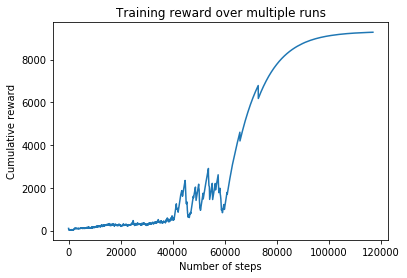

In [12]:
def numpy_ewma_vectorized_v2(data, window):

    alpha = 2 /(window + 1.0)
    alpha_rev = 1-alpha
    n = data.shape[0]

    pows = alpha_rev**(np.arange(n+1))

    scale_arr = 1/pows[:-1]
    offset = data[0]*pows[1:]
    pw0 = alpha*alpha_rev**(n-1)

    mult = data*pw0*scale_arr
    cumsums = mult.cumsum()
    out = offset + cumsums*scale_arr[::-1]
    return out

plt.figure()
out = numpy_ewma_vectorized_v2(np.array(running_rewards_ddpg),20)
step_list_ddpg = np.array(step_list_ddpg)

plt.plot(step_list_ddpg, out)
plt.title('Training reward over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.show()

In [13]:
np.save('out.npy',out)
np.save('step_list_ddpg.npy',step_list_ddpg)

In [14]:
torch.save(ddpg.actor, 'FINALWEIGHTS_InvertedDoublePendulum_actor.pt')
torch.save(ddpg.actor_perturbed, 'FINALWEIGHTS_InvertedDoublePendulum_actor_perturbed.pt')
np.save('param_noise.npy',[param_noise.desired_action_stddev,
                           param_noise.adaptation_coefficient,
                           param_noise.current_stddev])

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type actor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [15]:
pnl = np.load('param_noise.npy')
ddpg.actor = torch.load('FINALWEIGHTS_InvertedDoublePendulum_actor.pt')
ddpg.actor_perturbed = torch.load('FINALWEIGHTS_InvertedDoublePendulum_actor_perturbed.pt')


In [16]:
env_name = 'InvertedDoublePendulum-v1'
env1 = gym.make(env_name)

# check whether the environment is discrete or continuous
discrete = isinstance(env.action_space, gym.spaces.Discrete)
obs_dim = env1.observation_space.shape[0]
act_dim = env1.action_space.n if discrete else env.action_space.shape[0]
if discrete: print("This is a discrete action space, probably not the right algorithm to use")


logdir='./DDPG_final/'
logging_interval = 20
animate_interval = logging_interval * 5
VISUALIZE = True
if VISUALIZE:
    if not os.path.exists(logdir):
        os.mkdir(logdir)
    env1 = gym.wrappers.Monitor(env1, logdir, force=True, video_callable=lambda \
                               episode_id: episode_id%logging_interval==0)
env1._max_episodes_steps = MAX_PATH_LENGTH

env1 = NormalizeAction(env1) # remap action values for the environment


[2018-06-04 17:41:55,178] Making new env: InvertedDoublePendulum-v1
[2018-06-04 17:41:55,186] Clearing 4 monitor files from previous run (because force=True was provided)


In [17]:
for i in range(2):
    SEED = 0   
    torch.manual_seed(SEED)
    np.random.seed(SEED)
    s1 = env1.reset() # get initial state
    # env1.render()
    # time.sleep(0.05)
    count=0
    param_noise = AdaptiveParamNoiseSpec(pnl[2],pnl[0],pnl[1])
    while True: # for each episode, we loop each step in this episode
        ddpg.noise.reset()
        env1.render()
        time.sleep(0.05)
        # use actor to get action, add ddpg.noise.step() to action
        # remember to put NN in eval mode while testing (to deal with BatchNorm layers) and put it back 
        # to train mode after you're done getting the action
        a1 = ddpg.action(s1, ddpg.noise.step(), param_noise)
        s1_1, r1, done1, _ = env1.step(a1)
        s1 = s1_1
        if done1: break
        count+=1
print('Finish Visualization')

[2018-06-04 17:41:58,110] Starting new video recorder writing to /datasets/home/04/004/l5shi/invDoublePendulem/DDPG_final/openaigym.video.0.2581.video000000.mp4
[2018-06-04 17:41:58,113] GLFW error: 65544, desc: b'X11: RandR gamma ramp support seems broken'
[2018-06-04 17:41:58,161] GLFW error: 65544, desc: b'Linux: Failed to watch for joystick connections in /dev/input: No such file or directory'
[2018-06-04 17:41:58,162] GLFW error: 65544, desc: b'Linux: Failed to open joystick device directory /dev/input: No such file or directory'


Finish Visualization


In [18]:
count

999

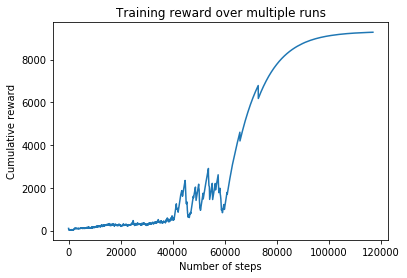

In [19]:
out=np.load('out.npy')
step_list_ddpg=np.load('step_list_ddpg.npy')

plt.plot(step_list_ddpg, out)
plt.title('Training reward over multiple runs')
plt.xlabel('Number of steps')
plt.ylabel('Cumulative reward')
plt.show()